# COMPSCI589 Homework 2
##### Chang Liu, 3.6.2022

## Programming: Multinomial Naive Bayes for Document Classification

In [83]:
# utils.py

import re
import os
import glob
import random
from nltk.corpus import stopwords
import nltk

REPLACE_NO_SPACE = re.compile("[._;:!`¦\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
nltk.download('stopwords')  

def preprocess_text(text):
	stop_words = set(stopwords.words('english'))
	text = REPLACE_NO_SPACE.sub("", text)
	text = REPLACE_WITH_SPACE.sub(" ", text)
	text = re.sub(r'\d+', '', text)
	text = text.lower()
	words = text.split()
	return [w for w in words if w not in stop_words]

def load_training_set(percentage_positives, percentage_negatives):
	vocab = set()
	positive_instances = []
	negative_instances = []
	for filename in glob.glob('train/pos/*.txt'):
		if random.random() > percentage_positives:
			continue
		with open(os.path.join(os.getcwd(), filename), 'r') as f:
			contents = f.read()
			contents = preprocess_text(contents)
			positive_instances.append(contents)
			vocab = vocab.union(set(contents))
	for filename in glob.glob('train/neg/*.txt'):
		if random.random() > percentage_negatives:
			continue
		with open(os.path.join(os.getcwd(), filename), 'r') as f:
			contents = f.read()
			contents = preprocess_text(contents)
			negative_instances.append(contents)
			vocab = vocab.union(set(contents))	
	return positive_instances, negative_instances, vocab

def load_test_set(percentage_positives, percentage_negatives):
	positive_instances = []
	negative_instances = []
	for filename in glob.glob('test/pos/*.txt'):
		if random.random() > percentage_positives:
			continue
		with open(os.path.join(os.getcwd(), filename), 'r') as f:
			contents = f.read()
			contents = preprocess_text(contents)
			positive_instances.append(contents)
	for filename in glob.glob('test/neg/*.txt'):
		if random.random() > percentage_negatives:
			continue
		with open(os.path.join(os.getcwd(), filename), 'r') as f:
			contents = f.read()
			contents = preprocess_text(contents)
			negative_instances.append(contents)
	return positive_instances, negative_instances
	

[nltk_data] Downloading package stopwords to /Users/von/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [84]:
# run.py
# from utils import *
import pprint
from collections import Counter
import math

def naive_bayes(data_percentage, smooth=True, log_likelihood=True):
	
	percentage_positive_instances_train = data_percentage
	percentage_negative_instances_train = data_percentage

	percentage_positive_instances_test  = data_percentage
	percentage_negative_instances_test  = data_percentage
	
	(pos_train, neg_train, vocab) = load_training_set(percentage_positive_instances_train, percentage_negative_instances_train)
	(pos_test,  neg_test)         = load_test_set(percentage_positive_instances_test, percentage_negative_instances_test)

	# print("Number of positive training instances:", len(pos_train))
	# print("Number of negative training instances:", len(neg_train))
	# print("Number of positive test instances:", len(pos_test))
	# print("Number of negative test instances:", len(neg_test))

	with open('vocab.txt','w') as f:
		for word in vocab:
			f.write("%s\n" % word)
	# print("Vocabulary (training set):", len(vocab))

	vocab_size = len(vocab)
	# Calculate the prior probabilities
	prior_pos = len(pos_train) / (len(pos_train) + len(neg_train))
	prior_neg = len(neg_train) / (len(pos_train) + len(neg_train))

	# print("Prior probability of positive class:", prior_pos)
	# print("Prior probability of negative class:", prior_neg)

	# Build the likelihoods table
	train_dict = {}
	for word in vocab:
		train_dict[word] = 0;
	
	likelihoods = {}
	likelihoods["pos"] = train_dict.copy()
	likelihoods["pos"].update( dict(Counter(sum(pos_train, []))) )
	likelihoods["neg"] = train_dict.copy()
	likelihoods["neg"].update( dict(Counter(sum(neg_train, []))) )

	word_count_pos = sum(likelihoods["pos"].values()) 
	word_count_neg = sum(likelihoods["neg"].values())

	model_pos = {}
	model_neg = {}

	# calculate probablity, apply lapalce smoothing 
	for word in likelihoods["pos"]:
		if smooth:
			model_pos[word] = (likelihoods["pos"][word] + 1) / (word_count_pos + vocab_size) 
		else:
			model_pos[word] = likelihoods["pos"][word] / word_count_pos

	for word in likelihoods["neg"]:
		if smooth:
			model_neg[word] = (likelihoods["neg"][word] + 1) / (word_count_neg + vocab_size)
		else:
			model_neg[word] = likelihoods["neg"][word] / word_count_neg

	pos_test_correct = 0
	for doc in pos_test:
		doc_dict = dict(Counter(doc))
		doc_p_pos = math.log(prior_pos) if log_likelihood else prior_pos
		doc_p_neg = math.log(prior_neg) if log_likelihood else prior_neg
		for word in doc_dict:
			if word in model_pos: 
				# it should also exist in the negative vacabulary
				if log_likelihood:
					doc_p_pos += math.log(model_pos[word]) if model_pos[word] != 0 else 0
					doc_p_neg += math.log(model_neg[word]) if model_neg[word] != 0 else 0
				else: 
					doc_p_pos *= model_pos[word]
					doc_p_neg *= model_neg[word]
		if (doc_p_pos > doc_p_neg):
			pos_test_correct += 1

	neg_test_correct = 0
	for doc in neg_test:
		doc_dict = dict(Counter(doc))
		doc_p_pos = math.log(prior_pos) if log_likelihood else prior_pos
		doc_p_neg = math.log(prior_neg) if log_likelihood else prior_neg
		for word in doc_dict:
			if word in model_pos:
				# it should also exist in the negative vacabulary
				if log_likelihood:
					doc_p_pos += math.log(model_pos[word]) if model_pos[word] != 0 else 0
					doc_p_neg += math.log(model_neg[word]) if model_neg[word] != 0 else 0
				else:
					doc_p_pos *= model_pos[word]
					doc_p_neg *= model_neg[word]
		if (doc_p_pos < doc_p_neg):
			neg_test_correct += 1

	# print("correct Pos Test: ", pos_test_correct);
	# print("correct Neg Test: ", neg_test_correct);
	
	accuracy = (pos_test_correct + neg_test_correct) / (len(pos_test) + len(neg_test))
	precision = pos_test_correct / (pos_test_correct + len(neg_test) - neg_test_correct)
	recall = pos_test_correct / len(pos_test)
	confusion_matrix = [[pos_test_correct, len(pos_test) - pos_test_correct], [len(neg_test) - neg_test_correct, neg_test_correct]]
	return accuracy, precision, recall, confusion_matrix


## Q.1 The Log-transformation trick

### Without using the log-transformation trick

for a new Doc,
$$ 
Pr(y_i | Doc) = Pr(y_i) \prod_{k=1}^{len(Doc)} Pr(w_k | y_i) 
$$

In [85]:
(acc, pre, rec, conf) = naive_bayes(0.2, smooth=False, log_likelihood=False)
print("| **Accuracy** | **Precision** | **Recall** |")
print("| :---: | :---: | :---: |")
print("|{} | {} | {} |".format(acc, pre, rec))
print("Confusion Matrix:")
print("|  | **Predicted +** | **Predicted-** |")
print("| :--- | :--- | :--- |")
print("| **Actual +** | {} | {} |".format(conf[0][0], conf[0][1]))
print("| **Actual -** | {} | {} |".format(conf[1][0], conf[1][1]))


| **Accuracy** | **Precision** | **Recall** |
| :---: | :---: | :---: |
|0.2673583399840383 | 0.26143790849673204 | 0.25559105431309903 |
Confusion Matrix:
|  | **Predicted +** | **Predicted-** |
| :--- | :--- | :--- |
| **Actual +** | 640 | 1864 |
| **Actual -** | 1808 | 700 |


### Using the log-transformation trick

for a new Doc,
$$ 
log(Pr(y_i | Doc)) = log(Pr(y_i)) + \sum_{k=1}^{len(Doc)} log(Pr(w_k | y_i) )
$$

In [86]:
(acc, pre, rec, conf) = naive_bayes(0.2, smooth=False, log_likelihood=True)
print("| **Accuracy** | **Precision** | **Recall** |")
print("| :---: | :---: | :---: |")
print("|{} | {} | {} |".format(acc, pre, rec))
print("Confusion Matrix:")
print("|  | **Predicted +** | **Predicted-** |")
print("| :--- | :--- | :--- |")
print("| **Actual +** | {} | {} |".format(conf[0][0], conf[0][1]))
print("| **Actual -** | {} | {} |".format(conf[1][0], conf[1][1]))

| **Accuracy** | **Precision** | **Recall** |
| :---: | :---: | :---: |
|0.5869565217391305 | 0.5877587758775877 | 0.5266129032258065 |
Confusion Matrix:
|  | **Predicted +** | **Predicted-** |
| :--- | :--- | :--- |
| **Actual +** | 1306 | 1174 |
| **Actual -** | 916 | 1664 |


### Accuracy, precision, recall

#### not using the log-transformation trick

| **Accuracy** | **Precision** | **Recall** |
| :---: | :---: | :---: |
|0.2673583399840383 | 0.26143790849673204 | 0.25559105431309903 |

#### vs using the trick

| **Accuracy** | **Precision** | **Recall** |
| :---: | :---: | :---: |
|0.5869565217391305 | 0.5877587758775877 | 0.5266129032258065 |


#### Confusion Matrix not using the log-transformation trick
  
|  | **Predicted +** | **Predicted-** |
| :--- | :--- | :--- |
| **Actual +** | 640 | 1864 |
| **Actual -** | 1808 | 700 |

#### vs using the trick

|  | **Predicted +** | **Predicted-** |
| :--- | :--- | :--- |
| **Actual +** | 1306 | 1174 |
| **Actual -** | 916 | 1664 |

> Discuss whether classifying instances by computing log-probabilities, instead of probabilities, affects the model’s performance. Assuming that this transformation does have an impact on performance, does it affect more strongly the model’s accuracy, precision, or recall? Why do you think that is the case?

We can see that using the log-transformation trick does helped a lot with improving the accuracy, the precision, and the recall. I think that's because it solve the problem that the probability could go very low when chaining multiple times, thus brought up the number of true possitive and true negative while lowering the number of false possitive and false negative.

## Q.2 laplace smoothing

In [87]:
(acc, pre, rec, conf) = naive_bayes(0.2, smooth=True, log_likelihood=True)
print("| **Accuracy** | **Precision** | **Recall** |")
print("| :---: | :---: | :---: |")
print("|{} | {} | {} |".format(acc, pre, rec))
print("Confusion Matrix:")
print("|  | **Predicted +** | **Predicted-** |")
print("| :--- | :--- | :--- |")
print("| **Actual +** | {} | {} |".format(conf[0][0], conf[0][1]))
print("| **Actual -** | {} | {} |".format(conf[1][0], conf[1][1]))

| **Accuracy** | **Precision** | **Recall** |
| :---: | :---: | :---: |
|0.8204414396500298 | 0.8489991296779809 | 0.7782209812524931 |
Confusion Matrix:
|  | **Predicted +** | **Predicted-** |
| :--- | :--- | :--- |
| **Actual +** | 1951 | 556 |
| **Actual -** | 347 | 2175 |


### Date with laplace smoothing, while $\alpha= 1$ 

| **Accuracy** | **Precision** | **Recall** |
| :---: | :---: | :---: |
|0.8204414396500298 | 0.8489991296779809 | 0.7782209812524931 |

Confusion Matrix:
|  | **Predicted +** | **Predicted-** |
| :--- | :--- | :--- |
| **Actual +** | 1951 | 556 |
| **Actual -** | 347 | 2175 |

In [ ]:
import pprint
from collections import Counter
import math

def naive_bayes_smoothing_plot(data_percentage):
	
	percentage_positive_instances_train = data_percentage
	percentage_negative_instances_train = data_percentage

	percentage_positive_instances_test  = data_percentage
	percentage_negative_instances_test  = data_percentage
	
	(pos_train, neg_train, vocab) = load_training_set(percentage_positive_instances_train, percentage_negative_instances_train)
	(pos_test,  neg_test)         = load_test_set(percentage_positive_instances_test, percentage_negative_instances_test)

	alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
	accuracies = [ deploy_nb_with_smoothing(pos_train, neg_train, vocab, pos_test, neg_test, alpha) for alpha in alphas]
	return alphas, accuracies

def deploy_nb_with_smoothing(pos_train, neg_train, vocab, pos_test, neg_test, alpha):

	vocab_size = len(vocab)
	# Calculate the prior probabilities
	prior_pos = len(pos_train) / (len(pos_train) + len(neg_train))
	prior_neg = len(neg_train) / (len(pos_train) + len(neg_train))


	train_dict = {}
	for word in vocab:
		train_dict[word] = 0;
	
	likelihoods = {}
	likelihoods["pos"] = train_dict.copy()
	likelihoods["pos"].update( dict(Counter(sum(pos_train, []))) )
	likelihoods["neg"] = train_dict.copy()
	likelihoods["neg"].update( dict(Counter(sum(neg_train, []))) )

	word_count_pos = sum(likelihoods["pos"].values()) 
	word_count_neg = sum(likelihoods["neg"].values())

	model_pos = {}
	model_neg = {}

	# calculate probablity, apply lapalce smoothing 
	for word in likelihoods["pos"]:
		model_pos[word] = (likelihoods["pos"][word] + alpha) / (word_count_pos + vocab_size*alpha) 

	for word in likelihoods["neg"]:
		model_neg[word] = (likelihoods["neg"][word] + alpha) / (word_count_neg + vocab_size*alpha)

	pos_test_correct = 0
	for doc in pos_test:
		doc_dict = dict(Counter(doc))
		doc_p_pos = math.log(prior_pos) 
		doc_p_neg = math.log(prior_neg) 
		for word in doc_dict:
			if word in model_pos: 
				# it should also exist in the negative vacabulary
				doc_p_pos += math.log(model_pos[word]) if model_pos[word] != 0 else 0
				doc_p_neg += math.log(model_neg[word]) if model_neg[word] != 0 else 0
		if (doc_p_pos > doc_p_neg):
			pos_test_correct += 1

	neg_test_correct = 0
	for doc in neg_test:
		doc_dict = dict(Counter(doc))
		doc_p_pos = math.log(prior_pos) 
		doc_p_neg = math.log(prior_neg) 
		for word in doc_dict:
			if word in model_pos:
				# it should also exist in the negative vacabulary
				doc_p_pos += math.log(model_pos[word]) if model_pos[word] != 0 else 0
				doc_p_neg += math.log(model_neg[word]) if model_neg[word] != 0 else 0
		if (doc_p_pos < doc_p_neg):
			neg_test_correct += 1

	accuracy = (pos_test_correct + neg_test_correct) / (len(pos_test) + len(neg_test))
	return accuracy

(alphas, accuracies) = naive_bayes_smoothing_plot(0.2)

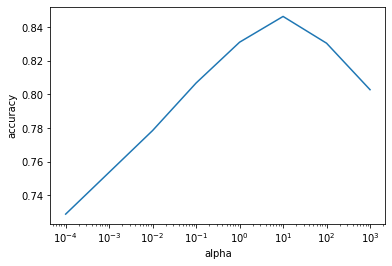

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(alphas, accuracies)
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.xscale('log')
plt.show()

> Analyze this graph and discuss why do you think the accuracy suffers when α is too high or too low.

The graph reaches a peak between $\alpha=10^1$ and $\alpha=10^2$. The accuracy suffers when $\alpha$ is too low or too high because $\alpha$ become either too dominant or have too little effect in the fraction.

## Q.3 Whole training set

In [88]:
# actually q_3_4
def naive_bayes_q_4_5(percentage_train, smooth_alpha, log_likelihood=True):
    
	percentage_positive_instances_train = percentage_train
	percentage_negative_instances_train = percentage_train

	percentage_positive_instances_test  = 1
	percentage_negative_instances_test  = 1
	
	(pos_train, neg_train, vocab) = load_training_set(percentage_positive_instances_train, percentage_negative_instances_train)
	(pos_test,  neg_test)         = load_test_set(percentage_positive_instances_test, percentage_negative_instances_test)

	# print("Number of positive training instances:", len(pos_train))
	# print("Number of negative training instances:", len(neg_train))
	# print("Number of positive test instances:", len(pos_test))
	# print("Number of negative test instances:", len(neg_test))

	with open('vocab.txt','w') as f:
		for word in vocab:
			f.write("%s\n" % word)
	# print("Vocabulary (training set):", len(vocab))

	vocab_size = len(vocab)
	# Calculate the prior probabilities
	prior_pos = len(pos_train) / (len(pos_train) + len(neg_train))
	prior_neg = len(neg_train) / (len(pos_train) + len(neg_train))

	# print("Prior probability of positive class:", prior_pos)
	# print("Prior probability of negative class:", prior_neg)

	# Build the likelihoods table
	train_dict = {}
	for word in vocab:
		train_dict[word] = 0;
	
	likelihoods = {}
	likelihoods["pos"] = train_dict.copy()
	likelihoods["pos"].update( dict(Counter(sum(pos_train, []))) )
	likelihoods["neg"] = train_dict.copy()
	likelihoods["neg"].update( dict(Counter(sum(neg_train, []))) )

	word_count_pos = sum(likelihoods["pos"].values()) 
	word_count_neg = sum(likelihoods["neg"].values())

	model_pos = {}
	model_neg = {}

	# calculate probablity, apply lapalce smoothing 
	for word in likelihoods["pos"]:
		model_pos[word] = (likelihoods["pos"][word] + smooth_alpha) / (word_count_pos + vocab_size*smooth_alpha) 

	for word in likelihoods["neg"]:
		model_neg[word] = (likelihoods["neg"][word] + smooth_alpha) / (word_count_neg + vocab_size*smooth_alpha)

	pos_test_correct = 0
	for doc in pos_test:
		doc_dict = dict(Counter(doc))
		doc_p_pos = math.log(prior_pos) if log_likelihood else prior_pos
		doc_p_neg = math.log(prior_neg) if log_likelihood else prior_neg
		for word in doc_dict:
			if word in model_pos: 
				# it should also exist in the negative vacabulary
				if log_likelihood:
					doc_p_pos += math.log(model_pos[word]) if model_pos[word] != 0 else 0
					doc_p_neg += math.log(model_neg[word]) if model_neg[word] != 0 else 0
				else: 
					doc_p_pos *= model_pos[word]
					doc_p_neg *= model_neg[word]
		if (doc_p_pos > doc_p_neg):
			pos_test_correct += 1

	neg_test_correct = 0
	for doc in neg_test:
		doc_dict = dict(Counter(doc))
		doc_p_pos = math.log(prior_pos) if log_likelihood else prior_pos
		doc_p_neg = math.log(prior_neg) if log_likelihood else prior_neg
		for word in doc_dict:
			if word in model_pos:
				# it should also exist in the negative vacabulary
				if log_likelihood:
					doc_p_pos += math.log(model_pos[word]) if model_pos[word] != 0 else 0
					doc_p_neg += math.log(model_neg[word]) if model_neg[word] != 0 else 0
				else:
					doc_p_pos *= model_pos[word]
					doc_p_neg *= model_neg[word]
		if (doc_p_pos < doc_p_neg):
			neg_test_correct += 1

	# print("correct Pos Test: ", pos_test_correct);
	# print("correct Neg Test: ", neg_test_correct);
	
	accuracy = (pos_test_correct + neg_test_correct) / (len(pos_test) + len(neg_test))
	precision = pos_test_correct / (pos_test_correct + len(neg_test) - neg_test_correct)
	recall = pos_test_correct / len(pos_test)
	confusion_matrix = [[pos_test_correct, len(pos_test) - pos_test_correct], [len(neg_test) - neg_test_correct, neg_test_correct]]
	return accuracy, precision, recall, confusion_matrix

In [91]:
(acc, pre, rec, conf) = naive_bayes_q_4_5(1, 10, log_likelihood=True)
print("| **Accuracy** | **Precision** | **Recall** |")
print("| :---: | :---: | :---: |")
print("|{} | {} | {} |".format(acc, pre, rec))
print("Confusion Matrix:")
print("|  | **Predicted +** | **Predicted-** |")
print("| :--- | :--- | :--- |")
print("| **Actual +** | {} | {} |".format(conf[0][0], conf[0][1]))
print("| **Actual -** | {} | {} |".format(conf[1][0], conf[1][1]))

| **Accuracy** | **Precision** | **Recall** |
| :---: | :---: | :---: |
|0.84248 | 0.8748030117317458 | 0.79936 |
Confusion Matrix:
|  | **Predicted +** | **Predicted-** |
| :--- | :--- | :--- |
| **Actual +** | 9992 | 2508 |
| **Actual -** | 1430 | 11070 |


### Data when using the whole train dataset 

| **Accuracy** | **Precision** | **Recall** |
| :---: | :---: | :---: |
|0.84248 | 0.8748030117317458 | 0.79936 |

Confusion Matrix:
|  | **Predicted +** | **Predicted-** |
| :--- | :--- | :--- |
| **Actual +** | 9992 | 2508 |
| **Actual -** | 1430 | 11070 |

## Q.4 Half training set

In [123]:
(acc, pre, rec, conf) = naive_bayes_q_4_5(0.5, 10, log_likelihood=True)
print("| **Accuracy** | **Precision** | **Recall** |")
print("| :---: | :---: | :---: |")
print("|{} | {} | {} |".format(acc, pre, rec))
print("Confusion Matrix:")
print("|  | **Predicted +** | **Predicted-** |")
print("| :--- | :--- | :--- |")
print("| **Actual +** | {} | {} |".format(conf[0][0], conf[0][1]))
print("| **Actual -** | {} | {} |".format(conf[1][0], conf[1][1]))

| **Accuracy** | **Precision** | **Recall** |
| :---: | :---: | :---: |
|0.8276 | 0.8685868586858686 | 0.772 |
Confusion Matrix:
|  | **Predicted +** | **Predicted-** |
| :--- | :--- | :--- |
| **Actual +** | 9650 | 2850 |
| **Actual -** | 1460 | 11040 |


### Data when using half the train dataset 

| **Accuracy** | **Precision** | **Recall** |
| :---: | :---: | :---: |
|0.8436 | 0.8736082115518441 | 0.80344 |

Confusion Matrix:
|  | **Predicted +** | **Predicted-** |
| :--- | :--- | :--- |
| **Actual +** | 10043 | 2457 |
| **Actual -** | 1453 | 11047 |
   
 

> Discuss whether using such a smaller training set had any impact on the performance your learned model. Analyze the confusion matrices (of this question and the previous one) and discuss whether one particular class was more affected by changing the size of the training set.

It didn't make a big difference. I also tried to vary the $\alpha$ value, which also didn't make a big difference. I think the reason behind is that after a certain point, the precision will no long benefit from the increased size of the training set. 

## Q.5 accuracy vs precision vs recall

> In this application (i.e., accurately classifying movie reviews), would you say that it is more important to have high accuracy, high precision, or high recall? Justify your opinion.

I think it depends on how we want to use the model. For example, if we want to hide all the negative reviews, we should try to lower the rate of false positive, even though that might increase the rate of false negative, which means that we might also hide some of the positive reviews. In that case, we should try to optimize for precision.

$$ precision = \frac{true\;positive}{true\;positive + false\;positive} $$ 

In other case, if we want to modify other recommandation system, or push ads to users that give out positive reviews, we should try to avoid false negative since we do not want to lose a potential user. In that case, we should try to optimize for recall.

$$ recall = \frac{true\;positive}{true\;positive + false\;negative} $$ 


## Q.6 Unbalanced training set


In [109]:
# actually q_3_4
def naive_bayes_unbalance(percentage_positive_instances_train, percentage_negative_instances_train, smooth_alpha, log_likelihood=True):
    
	percentage_positive_instances_test  = 1
	percentage_negative_instances_test  = 1
	
	(pos_train, neg_train, vocab) = load_training_set(percentage_positive_instances_train, percentage_negative_instances_train)
	(pos_test,  neg_test)         = load_test_set(percentage_positive_instances_test, percentage_negative_instances_test)

	# print("Number of positive training instances:", len(pos_train))
	# print("Number of negative training instances:", len(neg_train))
	# print("Number of positive test instances:", len(pos_test))
	# print("Number of negative test instances:", len(neg_test))

	with open('vocab.txt','w') as f:
		for word in vocab:
			f.write("%s\n" % word)
	# print("Vocabulary (training set):", len(vocab))

	vocab_size = len(vocab)
	# Calculate the prior probabilities
	prior_pos = len(pos_train) / (len(pos_train) + len(neg_train))
	prior_neg = len(neg_train) / (len(pos_train) + len(neg_train))

	# print("Prior probability of positive class:", prior_pos)
	# print("Prior probability of negative class:", prior_neg)

	# Build the likelihoods table
	train_dict = {}
	for word in vocab:
		train_dict[word] = 0;
	
	likelihoods = {}
	likelihoods["pos"] = train_dict.copy()
	likelihoods["pos"].update( dict(Counter(sum(pos_train, []))) )
	likelihoods["neg"] = train_dict.copy()
	likelihoods["neg"].update( dict(Counter(sum(neg_train, []))) )

	word_count_pos = sum(likelihoods["pos"].values()) 
	word_count_neg = sum(likelihoods["neg"].values())

	model_pos = {}
	model_neg = {}

	# calculate probablity, apply lapalce smoothing 
	for word in likelihoods["pos"]:
		model_pos[word] = (likelihoods["pos"][word] + smooth_alpha) / (word_count_pos + vocab_size*smooth_alpha) 

	for word in likelihoods["neg"]:
		model_neg[word] = (likelihoods["neg"][word] + smooth_alpha) / (word_count_neg + vocab_size*smooth_alpha)

	pos_test_correct = 0
	for doc in pos_test:
		doc_dict = dict(Counter(doc))
		doc_p_pos = math.log(prior_pos) if log_likelihood else prior_pos
		doc_p_neg = math.log(prior_neg) if log_likelihood else prior_neg
		for word in doc_dict:
			if word in model_pos: 
				# it should also exist in the negative vacabulary
				if log_likelihood:
					doc_p_pos += math.log(model_pos[word]) if model_pos[word] != 0 else 0
					doc_p_neg += math.log(model_neg[word]) if model_neg[word] != 0 else 0
				else: 
					doc_p_pos *= model_pos[word]
					doc_p_neg *= model_neg[word]
		if (doc_p_pos > doc_p_neg):
			pos_test_correct += 1

	neg_test_correct = 0
	for doc in neg_test:
		doc_dict = dict(Counter(doc))
		doc_p_pos = math.log(prior_pos) if log_likelihood else prior_pos
		doc_p_neg = math.log(prior_neg) if log_likelihood else prior_neg
		for word in doc_dict:
			if word in model_pos:
				# it should also exist in the negative vacabulary
				if log_likelihood:
					doc_p_pos += math.log(model_pos[word]) if model_pos[word] != 0 else 0
					doc_p_neg += math.log(model_neg[word]) if model_neg[word] != 0 else 0
				else:
					doc_p_pos *= model_pos[word]
					doc_p_neg *= model_neg[word]
		if (doc_p_pos < doc_p_neg):
			neg_test_correct += 1

	# print("correct Pos Test: ", pos_test_correct);
	# print("correct Neg Test: ", neg_test_correct);
	
	accuracy = (pos_test_correct + neg_test_correct) / (len(pos_test) + len(neg_test))
	precision = pos_test_correct / (pos_test_correct + len(neg_test) - neg_test_correct)
	recall = pos_test_correct / len(pos_test)
	confusion_matrix = [[pos_test_correct, len(pos_test) - pos_test_correct], [len(neg_test) - neg_test_correct, neg_test_correct]]
	return accuracy, precision, recall, confusion_matrix

In [122]:
(acc, pre, rec, conf) = naive_bayes_unbalance(0.1, 0.5, 1, log_likelihood=True)
print("| **Accuracy** | **Precision** | **Recall** |")
print("| :---: | :---: | :---: |")
print("|{} | {} | {} |".format(acc, pre, rec))
print("Confusion Matrix:") 
print("|  | **Predicted +** | **Predicted-** |")
print("| :--- | :--- | :--- |")
print("| **Actual +** | {} | {} |".format(conf[0][0], conf[0][1]))
print("| **Actual -** | {} | {} |".format(conf[1][0], conf[1][1]))

| **Accuracy** | **Precision** | **Recall** |
| :---: | :---: | :---: |
|0.60748 | 0.9459010952538998 | 0.228 |
Confusion Matrix:
|  | **Predicted +** | **Predicted-** |
| :--- | :--- | :--- |
| **Actual +** | 2850 | 9650 |
| **Actual -** | 163 | 12337 |


| **Accuracy** | **Precision** | **Recall** |
| :---: | :---: | :---: |
|0.60748 | 0.9459010952538998 | 0.228 |

Confusion Matrix:
|  | **Predicted +** | **Predicted-** |
| :--- | :--- | :--- |
| **Actual +** | 2850 | 9650 |
| **Actual -** | 163 | 12337 |      
     
### Discussion

> Discuss how training under an unbalanced dataset affected each of these performance metrics.

An unbalanced dataset will completely destroy the performance of the model since the model will be biased towards the majority class. At $alpha = 10$, the model actually classifies all the reviews as negitive, and precision = 0. I changed $alpha$ to 1, and the model still performs better than the balanced train set, but is better than $alpha = 10$. I think this is because the one class of the training set has only a small amount of data, and the lapace smoothing will smooth all the features of the data.